# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Personal Thoughts

I am excited to work on this project. This is a wonderful opportunity for me to learn about the state-of-the-art technology, Deep Learning, and dream about how I can make impacts on the world.

To tackle this project, I have been studying rigorously during my winter break. Well, the "break" they said. I finally understood what is Neural Network, Convolution Neural Networks, Back-propagation and few techniques to "fine-tune" my network including Adam Gradient Descent, Drop-out, Batch Normalization and Inception. While I understand that this is just a first step to the door, I am gratefully confident about the outcome of this class. 

Now, let's dive into my steps of how to train the computer regonize Traffic Sign itself. Teehee :d

---
## Step 0: Load The Data

I used 'pickle' to load the data. There are training set and test set in dataset. In a perfect world, DO NOT TOUCH test set until you believe that your network is good enough. 

The way I validated my network is to use cross-validation on minibatches. In particular, for every epoch, I divided my training set into 'BATCH_SIZE' (256) mini-batches. I used 20% of those batches as validation batches. I will go into detail about this in my 'network architechture'.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = '../data/train.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



In [2]:
### Replace each question mark with the appropriate value.
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
n_classes = len(set(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

## Display few Traffic Sign Samples

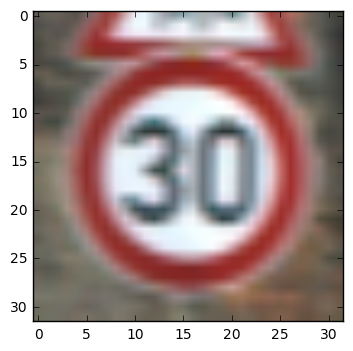

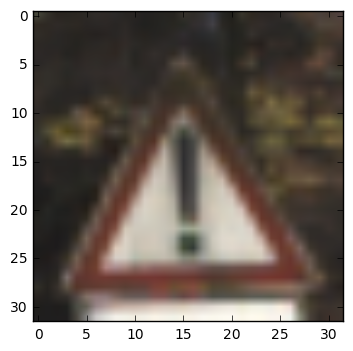

In [4]:
plt.figure(1)
plt.imshow(X_train[1000])
plt.figure(2)
plt.imshow(X_train[26000])

## Traffic Sign Sample Distribution

One might notice the quanity of each traffic sign is not distributed equally. For example, traffic sign ID '1' has much higher amount of images than traffic sign ID '0'. This could be an issue since the network will be more biased toward ID '1'. 

I will propose a way to solve this issue during data augmemtation.

39209 Observations


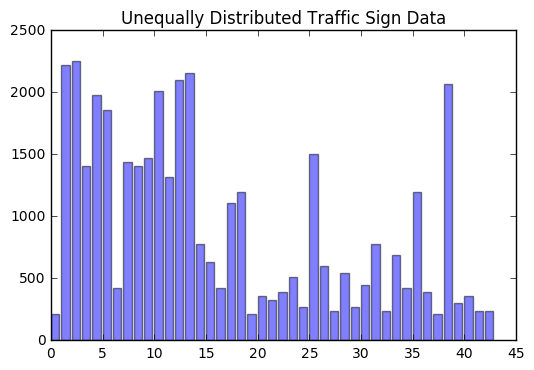

In [5]:
import numpy as np
# Create a barchart of frequencies
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (y_train.shape[0]))
plt.bar(item, count, alpha=0.5)
plt.title('Unequally Distributed Traffic Sign Data')

# Data Augmentation

Since the traffic sign samples is not distrubted equally, this could affect the CNN's performance. The network would be biased toward classes with more samples.

One possible solution is to do **data augmentation** on the original data. This techquie generates additional data on each traffic sign based on how much data it has. For example, if the average sample for each classes is 1000 images. Any class has less than 300 images need to generate more data. 

Data Augmentation includes but not limited to *blurring, rotating, shifting, darking* on original images.

For image transformation, I found this documentation is helpful: http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html

This library seems promising. However, I want to implement the code once before using it:
https://github.com/aleju/imgaug

## 1. Image Transformation Methods

Before generating data, we need to write some methods to transform orginal image. Below are my proposed methods: translation, rotation, affirm transformation, blur, brighten, darken an image.

All the methods will generate new image at different random levels (using numpy.random)

In [6]:
import cv2
import numpy as np

def translate(img):
    x = img.shape[0]
    y = img.shape[1]

    x_shift = np.random.uniform(-0.3 * x, 0.3 * x)
    y_shift = np.random.uniform(-0.3 * y, 0.3 * y)

    shift_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shift_img = cv2.warpAffine(img, shift_matrix, (x, y))

    return shift_img


def rotate(img):
    row, col, channel = img.shape

    angle = np.random.uniform(-180, 180)
    rotation_point = (row / 2, col / 2)
    rotation_matrix = cv2.getRotationMatrix2D(rotation_point, angle, 1)

    rotated_img = cv2.warpAffine(img, rotation_matrix, (col, row))
    return rotated_img


def shear(img):
    x, y, channel = img.shape

    shear = np.random.randint(5,15)
    pts1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
    pt1 = 5 + shear * np.random.uniform() - shear / 2
    pt2 = 20 + shear * np.random.uniform() - shear / 2
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    M = cv2.getAffineTransform(pts1, pts2)
    result = cv2.warpAffine(img, M, (y, x))
    return result


def blur(img):
    r_int = np.random.randint(0, 2)
    odd_size = 2 * r_int + 1
    return cv2.GaussianBlur(img, (odd_size, odd_size), 0)


def gamma(img):
    gamma = np.random.uniform(0.3, 1.5)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    new_img = cv2.LUT(img, table)
    return new_img

def pre_process(imgs):
    # imgs = imgs - np.mean(imgs)
    imgs  /= np.std(imgs, axis=0)
    return imgs

Let's test on a sample.

I generate 5 images per transformation on a random image of training set.

TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'B') according to the casting rule ''same_kind''

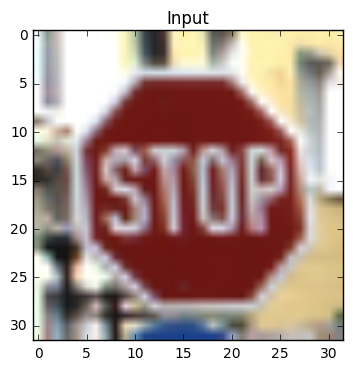

In [7]:
i = 22700

sample_1 = X_train[i]
plt.figure(1)
plt.imshow(sample_1), plt.title('Input')
test = pre_process(X_train)
plt.figure(2)
plt.imshow(test[22700],cmap='gray')

In [ ]:
i = 22700
sample_1 = X_train[i]
plt.figure(1)
plt.imshow(sample_1), plt.title('Input')

translated_img = []
rotated_img = []
shear_img = []
blur_img = []
noise_img = []
gamma_img=[]
for i in range(5):
    translated_img.append(translate(sample_1))
    rotated_img.append(rotate(sample_1))
    shear_img.append(shear(sample_1))
    blur_img.append(blur(sample_1))
    gamma_img.append(gamma(sample_1))

Let's visualize these images using matplotlib

In [ ]:
row = 5
col = 5
plt.subplot(row, col,1), plt.title('Shift')
plt.subplot(row, col,2), plt.title('Rotation')
plt.subplot(row, col,3), plt.title('Shear')
plt.subplot(row, col,4), plt.title('Blur')
plt.subplot(row, col,5), plt.title('Gamma')


for i in range(5):
    pos = 5*i
    plt.subplot(row, col,pos+1), plt.imshow(translated_img[i]),  plt.axis('off')
    plt.subplot(row, col,pos+2), plt.imshow(rotated_img[i]), plt.axis('off') 
    plt.subplot(row, col,pos+3), plt.imshow(shear_img[i]), plt.axis('off')
    plt.subplot(row, col,pos+4), plt.imshow(blur_img[i]), plt.axis('off')  
    plt.subplot(row, col,pos+5), plt.imshow(gamma_img[i]), plt.axis('off')

So far so good, now we create an algorithm to randomly select which transformation will be applied on image. That means one image could have multiple transformations.

In [ ]:
def random_transform(img):
    # There are total of 6 transformation
    # I will create an boolean array of 6 elements [ 0 or 1]
    a = np.random.randint(0, 2, [1, 5]).astype('bool')[0]
    if a[0] == 1: img = translate(img)
    if a[1] == 1: img = rotate(img)
    if a[2] == 1: img = shear(img)
    if a[3] == 1: img = blur(img)
    if a[4] == 1: img = gamma(img)
        
    return img

Let's test it on 30 km sign again

In [ ]:
for j in range(5):
    pos=5*j
    for i in range(8):
        test = random_transform(sample_1)
        plt.subplot(5, 7, pos+i+1), plt.imshow(test), plt.axis('off')

# 2. Generate New Dataset

We have a way to generate additional data now. However, each class in dataset should have different needed amount of additional data.

In this step, I will:
- Separate each class dataset.
- Compare number of dataset to average dataset/class.
- Based on that ration, I will decide to add more/less data into the current class

### 2.1 Separate Traffic Sign Data Set:
For every traffic sign, I decided to place in different arrays so that I could expand these later.

In [ ]:
total_traffic_signs = len(set(y_train))
print('There is total of ', total_traffic_signs, ' traffic signs.')

# Calculate how many images in one traffic sign
ts, imgs_per_sign = np.unique(y_train, return_counts=True)
avg_img_per_sign = np.ceil(np.mean(imgs_per_sign)).astype('uint32')
print(avg_img_per_sign, " is an average number of images per traffic sign.")


# Based on that average, we can estimate how many images a traffic sign need to have
# First, separate each traffic sign training set into different arrays
separated_data = []
for traffic_sign in range(total_traffic_signs):
    images_in_this_sign = X_train[y_train == traffic_sign,...]
    separated_data.append(images_in_this_sign)

print("\nIn the first traffic sign.")
print("There is ", separated_data[0].shape[0], ' images.')

### 2.2 Generate New Data Set:
So we have just separated each traffic sign into mini data sets instead of a giant 'X_train'.

For each mini data set, I used a so-called 'scale-factor' to demtermine how more data should I add to the original dataset. 'Scale-factor' is calculated by (Current Images/Average Images per set)*2 . 


The more data, the merrier. 

**This step takes some time. Be patient :)**


In [ ]:
# Second, for each dataset, I generate new images randomly based on current total images       
expanded_data = np.array(np.zeros((1, 32,32,3)))
expanded_labels = np.array([0])

for sign, sign_images in enumerate(separated_data):
    scale_factor = (2*(avg_img_per_sign/imgs_per_sign[sign])).astype('uint32')
    new_images = []

    # Generate new images  <---- Could apply list comprehension here
    for img in sign_images:
        for _ in range(scale_factor):
            new_images.append(random_transform(img))

    # Add old images and new images into 1 array    
    if len(new_images) > 0:
        sign_images = np.concatenate((sign_images, new_images),axis=0)
    new_labels = np.full(len(sign_images),sign, dtype ='uint8')
    # Insert new_images to current dataset
    expanded_data = np.concatenate((expanded_data,sign_images), axis = 0)
    expanded_labels = np.concatenate((expanded_labels, new_labels), axis=0)   

print(expanded_data.shape)
print(expanded_labels.shape)

### Compare Before and After Data Augmentation:

We just finished data augmentation. Let's visualize how our data is distributed.

In [ ]:
# Create a barchart of frequencies
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T

print('Before Data Augmentation: %d Observations' % (y_train.shape[0]))
plt.figure(1)
plt.bar(item, count, alpha=0.5)
plt.title('Before Data Augmentation: Unequally Distributed Data')

item2, count2 = np.unique(expanded_labels, return_counts=True)
freq2 = np.array((item2, count2)).T

print('After Data Augmentation: %d Observations' % (expanded_labels.shape[0]))
plt.figure(2)
plt.bar(item2, count2, alpha=0.5)
plt.title('After Data Augmentation: More Equally Distributed Data')

#  Pre-Processing Data

Before loading data into the CNN, I need to pre-process the dataset. One of important pre-process is 'zero-centered' data. Though many applied 'grayscale' images for training, I beleive CNN should be able to recognize colorful images.


In [ ]:
X_train, y_train = expanded_data, expanded_labels

X_train = X_train - np.mean(X_train)
X_train = X_train/np.std(X_train,axis=0)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

My proposed pipeline is:

- Pre-process data : Perform data augmentation, normalization on Y channel of YUV color space (Yann Lecun)
- Network Architecture: VGG-16
- 
There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.